Dataset loaded.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_3102/946229895.py:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beauti

NLTK data downloaded.
Epoch 1/10
84/84 [==============================] - 14s 149ms/step - loss: 0.4247 - accuracy: 0.8065 - val_loss: 0.2177 - val_accuracy: 0.9140
Epoch 2/10
84/84 [==============================] - 11s 136ms/step - loss: 0.0962 - accuracy: 0.9694 - val_loss: 0.1291 - val_accuracy: 0.9498
Epoch 3/10
84/84 [==============================] - 12s 146ms/step - loss: 0.0724 - accuracy: 0.9772 - val_loss: 0.1021 - val_accuracy: 0.9623
Epoch 4/10
84/84 [==============================] - 14s 167ms/step - loss: 0.0600 - accuracy: 0.9799 - val_loss: 0.0844 - val_accuracy: 0.9742
Epoch 5/10
82/82 [==============================] - 1s 13ms/step
Epoch 1/10
84/84 [==============================] - 16s 193ms/step - loss: 0.3655 - accuracy: 0.8853 - val_loss: 0.2265 - val_accuracy: 0.8939
Epoch 2/10
84/84 [==============================] - 13s 156ms/step - loss: 0.0946 - accuracy: 0.9679 - val_loss: 0.1295 - val_accuracy: 0.9494
Epoch 3/10
84/84 [==============================] - 12s

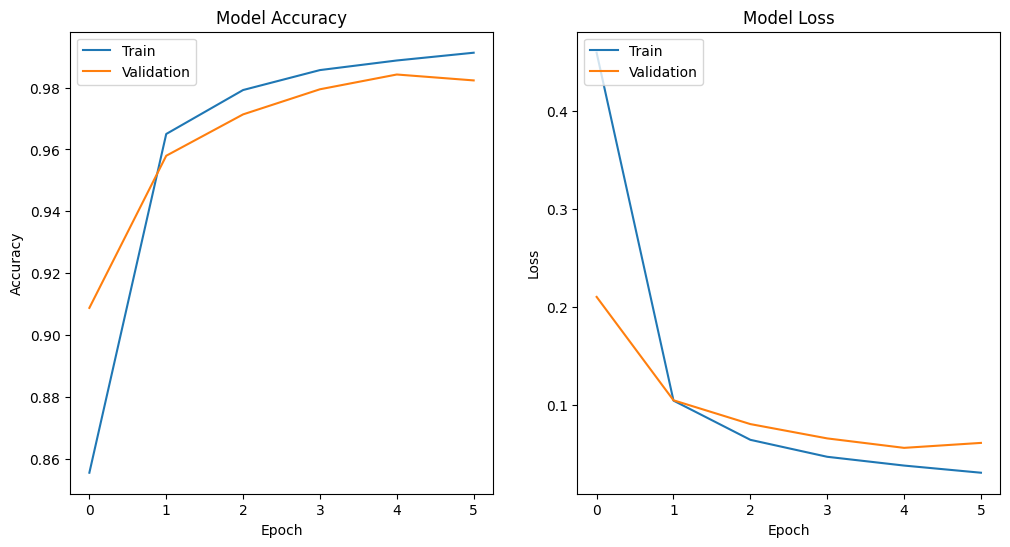

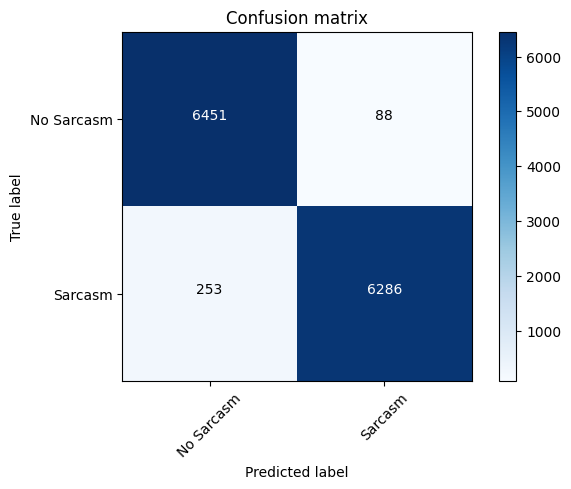

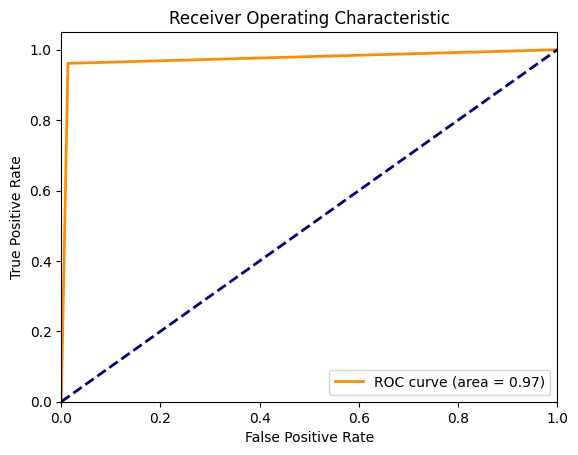

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6539
           1       0.99      0.96      0.97      6539

    accuracy                           0.97     13078
   macro avg       0.97      0.97      0.97     13078
weighted avg       0.97      0.97      0.97     13078



In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
# Load your dataset
dataset = pd.read_csv('annotated_comments_binary.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Sarcasm'] = dataset['Have_Sarcasm'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Sarcasm']

oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

def plot_history(history):
    plt.figure(figsize=(12, 6))
    
    # Plot for model accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot for model loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Save the figure
    plt.savefig('training_and_validation_accuracy.png', dpi=300)
    
    # Display the figure
    plt.show()

plot_history(history)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_cnn.png', dpi=300)  # Corrected indentation
    plt.show()

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('ROC_cnn.png', dpi=300)  # Corrected indentation
    plt.show()


# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Sarcasm", "Sarcasm"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('annotated_comments_binary.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Sarcasm'] = dataset['Have_Sarcasm'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Sarcasm']
#undersampler = RandomUnderSampler(random_state=42)
#X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

oversampler = RandomOverSampler(random_state=42)
X_resampled_over, y_resampled_over = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)


# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency_over(X_resampled, y_resampled, max_words, max_len):
#def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
   # return history, np.array(all_predictions), np.array(all_actuals)
 return history, np.array(all_predictions), np.array(all_actuals), fpr, tpr
# Train the model and get the history object, predictions, and actual values
#history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)
history_over, all_predictions_over, all_actuals_over, fpr_over, tpr_over = get_dataset_words_frequency_over(X_resampled_over, y_resampled_over, max_words, max_len)
# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Sarcasm", "Sarcasm"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 141)

Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_3102/1510611435.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beaut

Epoch 1/10
84/84 [==============================] - 12s 129ms/step - loss: 0.4365 - accuracy: 0.7867 - val_loss: 0.2285 - val_accuracy: 0.9025
Epoch 2/10
84/84 [==============================] - 10s 117ms/step - loss: 0.1013 - accuracy: 0.9645 - val_loss: 0.1241 - val_accuracy: 0.9479
Epoch 3/10
84/84 [==============================] - 11s 130ms/step - loss: 0.0771 - accuracy: 0.9743 - val_loss: 0.1143 - val_accuracy: 0.9570
Epoch 4/10
84/84 [==============================] - 10s 123ms/step - loss: 0.0632 - accuracy: 0.9786 - val_loss: 0.1013 - val_accuracy: 0.9666
Epoch 5/10
84/84 [==============================] - 11s 137ms/step - loss: 0.0518 - accuracy: 0.9835 - val_loss: 0.0895 - val_accuracy: 0.9728
Epoch 6/10
84/84 [==============================] - 11s 130ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0851 - val_accuracy: 0.9723
Epoch 7/10
84/84 [==============================] - 10s 123ms/step - loss: 0.0337 - accuracy: 0.9897 - val_loss: 0.0841 - val_accuracy: 0.9761

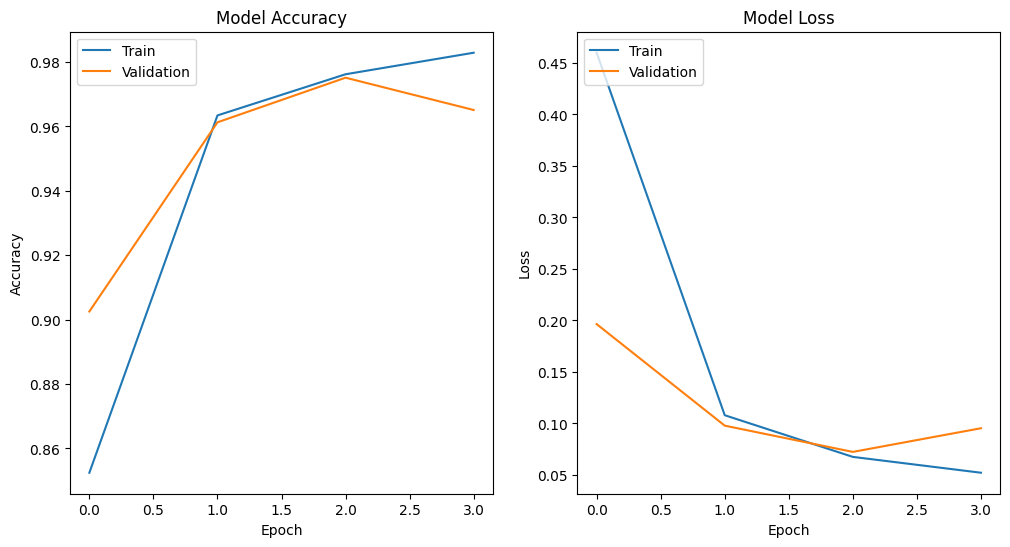

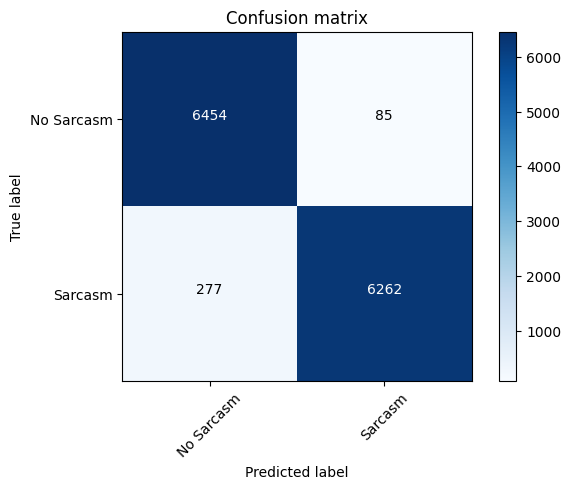

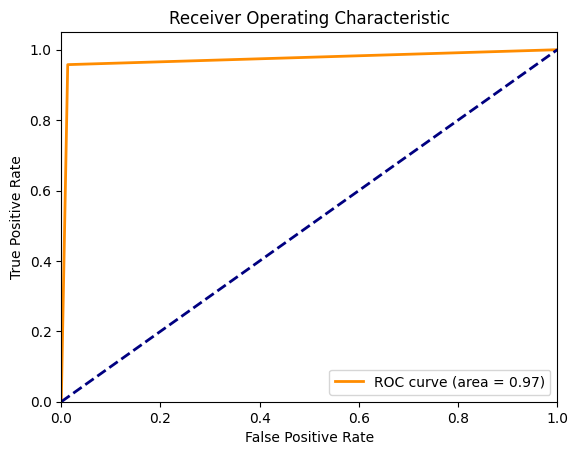

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6539
           1       0.99      0.96      0.97      6539

    accuracy                           0.97     13078
   macro avg       0.97      0.97      0.97     13078
weighted avg       0.97      0.97      0.97     13078



In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('annotated_comments_binary.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Sarcasm'] = dataset['Have_Sarcasm'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Sarcasm']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Sarcasm", "Sarcasm"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_3102/3011616295.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beaut

Epoch 1/10
45/45 [==============================] - 7s 126ms/step - loss: 0.5933 - accuracy: 0.6920 - val_loss: 0.6779 - val_accuracy: 0.5162
Epoch 2/10
45/45 [==============================] - 8s 179ms/step - loss: 0.2168 - accuracy: 0.9241 - val_loss: 0.1741 - val_accuracy: 0.9377
Epoch 3/10
45/45 [==============================] - 10s 217ms/step - loss: 0.0974 - accuracy: 0.9677 - val_loss: 0.1190 - val_accuracy: 0.9666
Epoch 4/10
44/44 [==============================] - 1s 13ms/step
Epoch 1/10
45/45 [==============================] - 5s 117ms/step - loss: 0.4898 - accuracy: 0.8324 - val_loss: 0.7075 - val_accuracy: 0.6958
Epoch 2/10
45/45 [==============================] - 6s 133ms/step - loss: 0.1532 - accuracy: 0.9472 - val_loss: 0.3106 - val_accuracy: 0.9016
Epoch 3/10
45/45 [==============================] - 6s 136ms/step - loss: 0.0994 - accuracy: 0.9639 - val_loss: 0.2232 - val_accuracy: 0.9350
Epoch 4/10
44/44 [==============================] - 1s 12ms/step
Epoch 1/10
45/45 

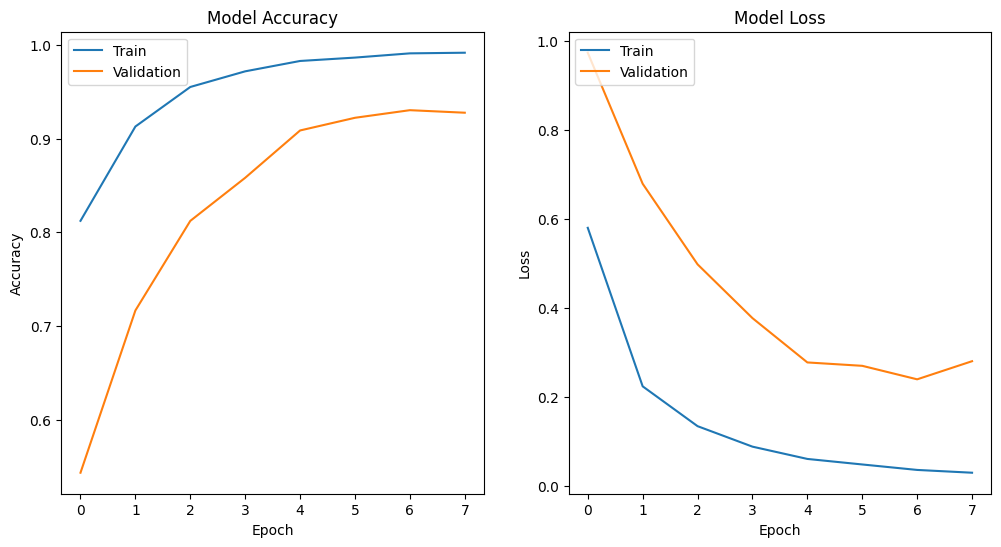

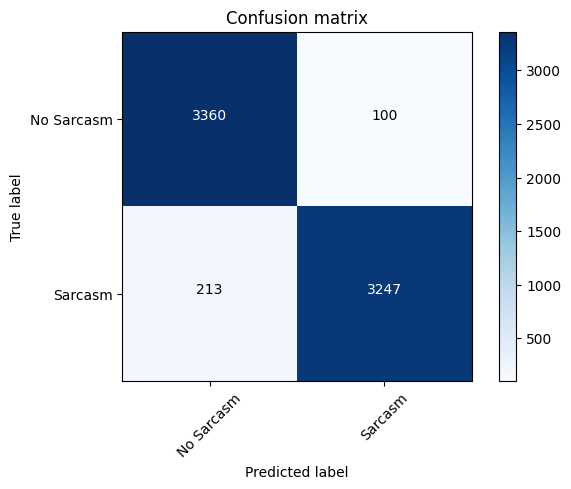

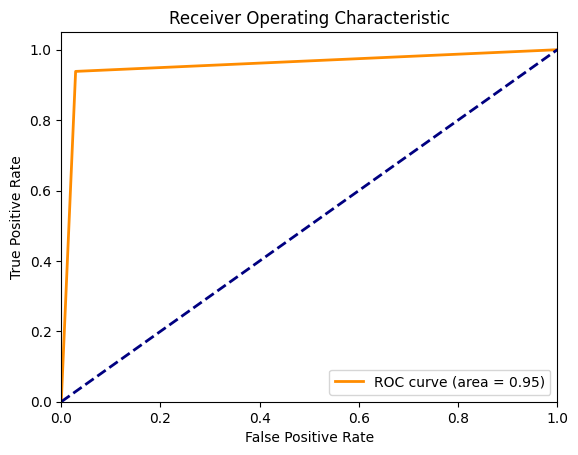

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3460
           1       0.97      0.94      0.95      3460

    accuracy                           0.95      6920
   macro avg       0.96      0.95      0.95      6920
weighted avg       0.96      0.95      0.95      6920



In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('annotated_comments_binary.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Sarcasm'] = dataset['Have_Sarcasm'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Sarcasm']
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predictions = []
    all_actuals = []

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Train the model
        history = cnn_model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Predict and evaluate
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = cnn_model.predict(test_sequences_matrix).round().flatten()
        acc_score.append(accuracy_score(Test_Y, predictions))
        all_predictions.extend(predictions)
        all_actuals.extend(Test_Y)

    avg_acc_score = sum(acc_score) / k
    print('Avg accuracy : {}'.format(avg_acc_score))
    return history, np.array(all_predictions), np.array(all_actuals)

# Train the model and get the history object, predictions, and actual values
history, all_predictions, all_actuals = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plotting ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(all_actuals, all_predictions, classes=["No Sarcasm", "Sarcasm"])
plot_roc_curve(all_actuals, all_predictions)

# Print classification report
print(classification_report(all_actuals, all_predictions))


Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_3102/367969547.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beauti

Epoch 1/10
84/84 [==============================] - 13s 140ms/step - loss: 0.4141 - accuracy: 0.8067 - val_loss: 0.1661 - val_accuracy: 0.9326
Epoch 2/10
84/84 [==============================] - 11s 131ms/step - loss: 0.0975 - accuracy: 0.9669 - val_loss: 0.0895 - val_accuracy: 0.9623
Epoch 3/10
82/82 [==============================] - 1s 11ms/step
Epoch 1/10
84/84 [==============================] - 14s 158ms/step - loss: 0.4206 - accuracy: 0.7989 - val_loss: 0.2202 - val_accuracy: 0.9064
Epoch 2/10
84/84 [==============================] - 11s 134ms/step - loss: 0.0997 - accuracy: 0.9671 - val_loss: 0.1605 - val_accuracy: 0.9427
Epoch 3/10
84/84 [==============================] - 12s 146ms/step - loss: 0.0778 - accuracy: 0.9738 - val_loss: 0.1266 - val_accuracy: 0.9537
Epoch 4/10
84/84 [==============================] - 11s 134ms/step - loss: 0.0654 - accuracy: 0.9778 - val_loss: 0.1107 - val_accuracy: 0.9613
Epoch 5/10
84/84 [==============================] - 11s 126ms/step - loss: 0.

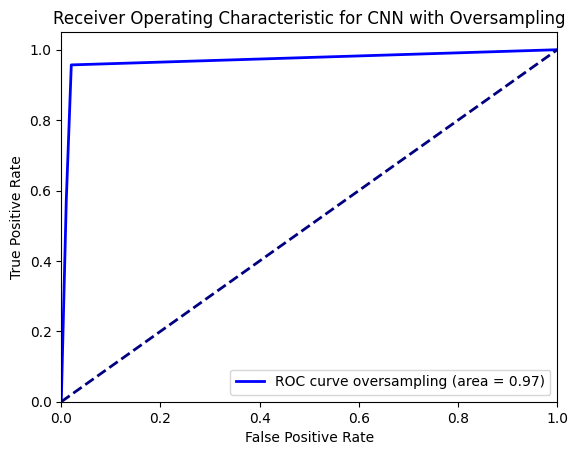

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6539
           1       0.98      0.96      0.97      6539

    accuracy                           0.97     13078
   macro avg       0.97      0.97      0.97     13078
weighted avg       0.97      0.97      0.97     13078



In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('annotated_comments_binary.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Sarcasm'] = dataset['Have_Sarcasm'].map({'Yes': 1, 'No': 0})

# Apply oversampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Sarcasm']
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score = []
    all_predicted_targets = []
    all_actual_targets = []
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Compile and train the model
        model = build_CNN_model()
        model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Evaluate the model
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = model.predict(test_sequences_matrix).round().flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(Test_Y, predictions)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Store actual and predicted values
        all_predicted_targets.extend(predictions)
        all_actual_targets.extend(Test_Y)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    return mean_fpr, mean_tpr, mean_auc, all_predicted_targets, all_actual_targets

# Get ROC data
mean_fpr_over, mean_tpr_over, mean_auc_over, all_predictions_over, all_actuals_over = get_dataset_words_frequency(X_resampled, y_resampled, max_words, max_len)

# Plot ROC Curve
plt.figure()
plt.plot(mean_fpr_over, mean_tpr_over, color='blue', lw=2, label='ROC curve oversampling (area = %0.2f)' % mean_auc_over)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CNN with Oversampling')
plt.legend(loc="lower right")
plt.show()

# Print classification report for oversampling
print(classification_report(all_actuals_over, all_predictions_over))


Dataset loaded.
NLTK data downloaded.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/var/folders/y0/23chrxcn0d9dv4pxp6v708kr0000gn/T/ipykernel_3102/3960707110.py:38: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beaut

Epoch 1/10
45/45 [==============================] - 6s 108ms/step - loss: 0.5912 - accuracy: 0.6775 - val_loss: 0.6073 - val_accuracy: 0.5894
Epoch 2/10
45/45 [==============================] - 5s 118ms/step - loss: 0.2100 - accuracy: 0.9234 - val_loss: 0.1928 - val_accuracy: 0.9314
Epoch 3/10
45/45 [==============================] - 5s 107ms/step - loss: 0.1025 - accuracy: 0.9636 - val_loss: 0.0978 - val_accuracy: 0.9747
Epoch 4/10
44/44 [==============================] - 0s 9ms/step
Epoch 1/10
45/45 [==============================] - 6s 111ms/step - loss: 0.5736 - accuracy: 0.7064 - val_loss: 0.5259 - val_accuracy: 0.6886
Epoch 2/10
45/45 [==============================] - 5s 101ms/step - loss: 0.2014 - accuracy: 0.9268 - val_loss: 0.1911 - val_accuracy: 0.9341
Epoch 3/10
45/45 [==============================] - 4s 99ms/step - loss: 0.0988 - accuracy: 0.9641 - val_loss: 0.1454 - val_accuracy: 0.9594
Epoch 4/10
45/45 [==============================] - 5s 100ms/step - loss: 0.0751 - ac

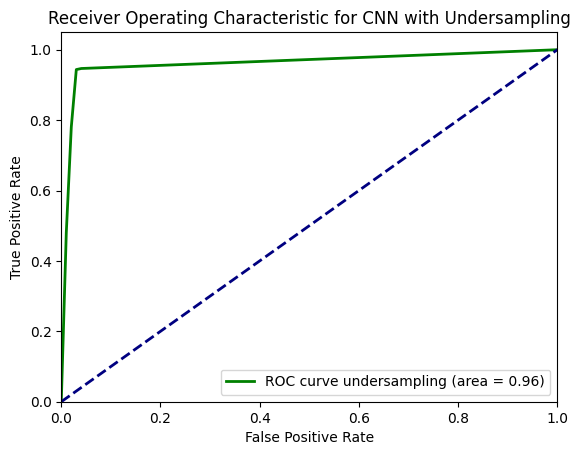

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3460
           1       0.98      0.95      0.96      3460

    accuracy                           0.96      6920
   macro avg       0.96      0.96      0.96      6920
weighted avg       0.96      0.96      0.96      6920



In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import itertools
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset
dataset = pd.read_csv('annotated_comments_binary.csv', encoding='latin-1')
print("Dataset loaded.")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('omw-1.4')
print("NLTK data downloaded.")

# Define preprocessing functions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

def clean_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\<\>\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z =#?+_]')
    text = strip_html(text) 
    text = remove_url(text)
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    return text

# Preprocess dataset
dataset['comment_Text'] = dataset['comment_Text'].apply(clean_text)
dataset['comment_Text'].dropna(inplace=True)
dataset['comment_Text'] = [entry.lower() for entry in dataset['comment_Text']]
dataset['comment_Text'] = [word_tokenize(entry) for entry in dataset['comment_Text']]

tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(dataset['comment_Text']):
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
    dataset.loc[index, 'text_final'] = str(Final_words)

# Map 'Yes'/'No' to 1/0
dataset['Have_Sarcasm'] = dataset['Have_Sarcasm'].map({'Yes': 1, 'No': 0})

# Apply undersampling to balance the classes
X = dataset['text_final']
y = dataset['Have_Sarcasm']
undersampler = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = undersampler.fit_resample(np.array(X).reshape(-1, 1), y)

# Set parameters for the model
max_words = 1000
max_len = 150

# Define the CNN model
def build_CNN_model():
    model = Sequential()
    model.add(Embedding(max_words, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Instantiate the model
cnn_model_under = build_CNN_model()

# Function to perform training and evaluation
def get_dataset_words_frequency_under(X_resampled, y_resampled, max_words, max_len):
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=1)
    acc_score_under = []
    all_predictions_under = []
    all_actuals_under = []
    tprs_under = []
    mean_fpr_under = np.linspace(0, 1, 100)

    for train_index, test_index in kf.split(X_resampled):
        Train_X, Test_X = X_resampled[train_index], X_resampled[test_index]
        Train_Y, Test_Y = y_resampled[train_index], y_resampled[test_index]

        Train_X = [x[0] for x in Train_X]
        Test_X = [x[0] for x in Test_X]

        # Tokenization and padding of sequences
        tok = Tokenizer(num_words=max_words)
        tok.fit_on_texts(Train_X)
        sequences = tok.texts_to_sequences(Train_X)
        sequences_matrix = pad_sequences(sequences, maxlen=max_len)

        # Compile and train the model
        model = build_CNN_model()
        model.fit(sequences_matrix, Train_Y, batch_size=100, epochs=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001)])
        
        # Evaluate the model
        test_sequences = tok.texts_to_sequences(Test_X)
        test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)
        predictions = model.predict(test_sequences_matrix).round().flatten()

        # ROC Curve
        fpr, tpr, _ = roc_curve(Test_Y, predictions)
        tprs_under.append(np.interp(mean_fpr_under, fpr, tpr))
        tprs_under[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        
        # Store actual and predicted values
        all_predictions_under.extend(predictions)
        all_actuals_under.extend(Test_Y)

    mean_tpr_under = np.mean(tprs_under, axis=0)
    mean_tpr_under[-1] = 1.0
    mean_auc_under = auc(mean_fpr_under, mean_tpr_under)

    return mean_fpr_under, mean_tpr_under, mean_auc_under, all_predictions_under, all_actuals_under

# Get ROC data for undersampling
mean_fpr_under, mean_tpr_under, mean_auc_under, all_predictions_under, all_actuals_under = get_dataset_words_frequency_under(X_resampled_under, y_resampled_under, max_words, max_len)

# Plot ROC Curve for Undersampling
plt.figure()
plt.plot(mean_fpr_under, mean_tpr_under, color='green', lw=2, label='ROC curve undersampling (area = %0.2f)' % mean_auc_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CNN with Undersampling')
plt.legend(loc="lower right")
plt.show()

# Print classification report for undersampling
print(classification_report(all_actuals_under, all_predictions_under))


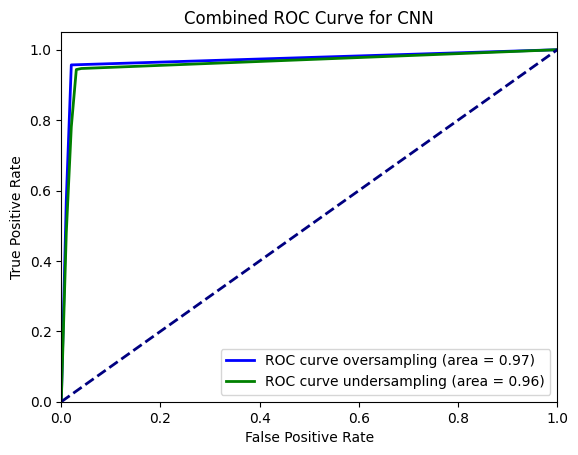

In [9]:
import matplotlib.pyplot as plt

# Make sure to run the oversampling and undersampling code blocks before this to get the ROC data
plt.figure()
plt.plot(mean_fpr_over, mean_tpr_over, color='blue', lw=2, label='ROC curve oversampling (area = %0.2f)' % mean_auc_over)
plt.plot(mean_fpr_under, mean_tpr_under, color='green', lw=2, label='ROC curve undersampling (area = %0.2f)' % mean_auc_under)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve for CNN')
plt.legend(loc="lower right")

# Save the plot
plt.savefig('combined_roc_curve.png', dpi=300)

plt.show()
